In [64]:
from lightglue import LightGlue, SuperPoint, DISK, SIFT, ALIKED, DoGHardNet
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch
from lightglue import match_pair
from itertools import combinations
import h5py
from pathlib import Path
import numpy as np

In [15]:
cd ..

C:\Users\davin\Desktop\Python\ML\DL\Image_Matching_2025


C:\Users\davin\Desktop\Python\ML\tfvenv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [28]:
def read_csv(path): 
    file_path = os.path.join(os.getcwd(),"image-matching-challenge-2025", path)
    return pd.read_csv(file_path)

In [29]:
df = read_csv("train_labels.csv")
df["image_path"] = df.apply(lambda row: os.path.join(os.getcwd(), "image-matching-challenge-2025", "train",  row["dataset"], row["image"]), axis=1)

In [18]:
def open_image(img_paths, scenes, n_cols=7, figsize=(15, 8)): 
    n_rows = len(img_paths) // 7 + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, img_path in enumerate(img_paths):
        #In case we have more images than subplots
        if i >= len(axes): 
            break
        img = cv2.imread(img_path)
        if img is None: 
            axes[i].set_title("No Image found")
            axes[i].axis("off")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].axis("off")
        axes[i].set_title(f"{scenes[i]}")
        
    for j in range(i+1, len(axes)): 
        axes[j].axis("off")
    plt.show()

In [19]:
scene_samples = df["scene"].values[:100]
img_path_samples = df["image_path"].values[:100]

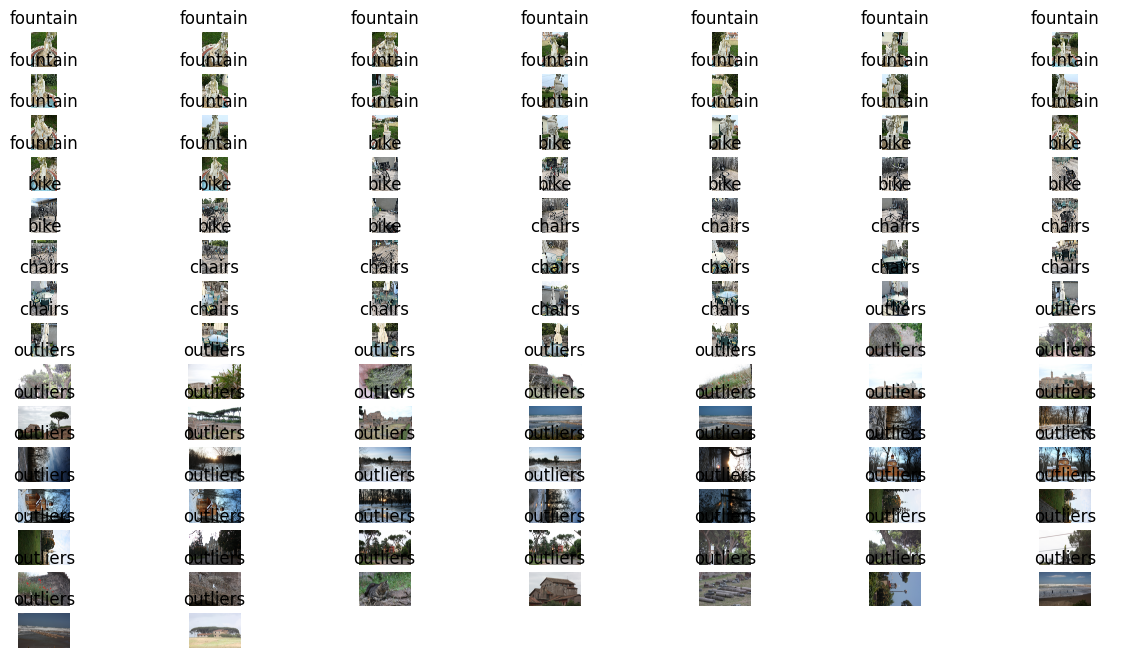

In [20]:
open_image(img_path_samples, scene_samples)

In [62]:
def get_pair_index(lst): 
    return list(itertools.combinations(range(lst)), 2)

def save_features_h5(filename, keypoints, descriptors): 
    if not isinstance(keypoints, np.ndarray): 
        keypoints = keypoints.cpu().numpy()
    if not isinstance(descriptors, np.ndarray): 
        descriptors = descriptors.cpu().numpy() 
    feature_dir = Path(os.getcwd()) / "feature_extraction"
    feature_dir.mkdir(parents=True, exist_ok=True)
    with h5py.File(feature_dir / filename, mode="w") as f:
        f.create_dataset("keypoints", data=keypoints)
        f.create_dataset("descriptors", data=descriptors)
                   
def compare_image(img0_path, img1_path, show_comparison, show_points=False):
    #Load the extractor and matcher
    extractor = ALIKED(max_num_keypoints=2048).eval()
    matcher = LightGlue(features="aliked", depth_confidence=1.0, width_confidence=1.0).eval()
    
    #load each image as a torch.Tensor
    image0 = load_image(img0_path)
    image1 = load_image(img1_path)
    
    #extract local features
    feats0 = extractor.extract(image0)
    feats1 = extractor.extract(image1)

    #Save features to HDF5 files 
    save_features_h5("image0_features.h5", feats0["keypoints"], feats0["descriptors"])
    
    #Match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
    matches = matches01['matches']
    points0 = feats0['keypoints'][matches[..., 0]]
    points1 = feats1['keypoints'][matches[..., 1]]
    print(len(points0))
    if show_comparison: 
        axes = viz2d.plot_images([image0, image1])
        viz2d.plot_matches(points0, points1, color="lime", lw=0.2)
        viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)
        kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
        viz2d.plot_images([image0, image1])
        viz2d.plot_keypoints([feats0["keypoints"], feats1["keypoints"]], colors=[kpc0, kpc1], ps=10)
    return points0, points1

264


(tensor([[ 877.6796, 1220.4287],
         [1101.3390, 1087.3740],
         [1204.8771, 1341.2532],
         [1338.4200, 1311.7708],
         [1290.5171, 1143.5316],
         [1018.6184, 1271.9646],
         [1055.9681, 1089.2858],
         [1228.1238, 1076.5331],
         [1329.4230,  514.4454],
         [1290.0905, 1098.2584],
         [1224.6842, 1144.2734],
         [1335.5001, 1339.9718],
         [1130.9664, 1058.8365],
         [ 482.5663, 1222.9097],
         [1033.0376, 1086.4910],
         [ 955.5418, 1199.1598],
         [1045.8345, 1118.8270],
         [1113.1624, 1158.7192],
         [ 958.6678, 1211.8898],
         [1153.1232, 1350.4705],
         [1150.4962, 1073.9968],
         [ 997.6761,  497.5153],
         [1281.0234, 1038.6996],
         [ 504.4562, 1162.5594],
         [ 751.7386, 1264.1969],
         [1273.6649,  523.5073],
         [1137.9049, 1281.4788],
         [1155.3717, 1089.2384],
         [1202.8870, 1299.8010],
         [1132.7600, 1173.0538],
         [

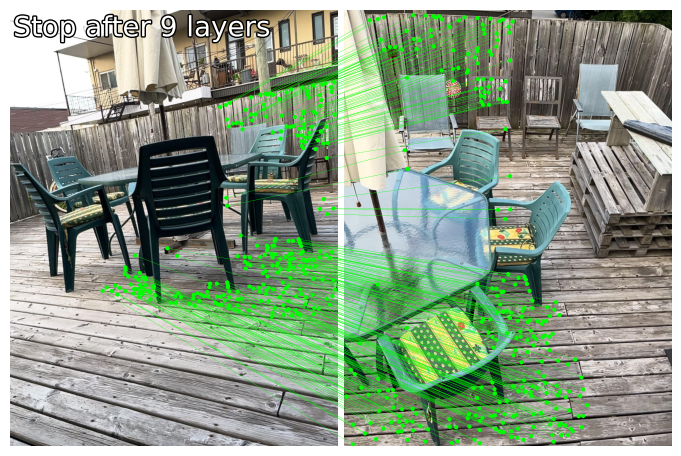

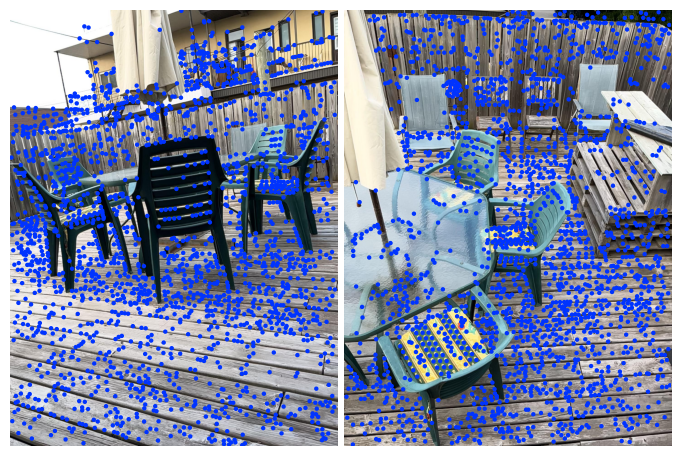

In [65]:
compare_image(img_path_samples[41], img_path_samples[43], True)